# Regional Growth Factor Model

In [2]:
# | default_exp model_utils

In [3]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
import jax
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import jax.random as jrn

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

In [4]:
# | export

key = jrn.PRNGKey(452342342345)
n_iterations = 20
N_mle = 1000
N_meis = 1000
N_posterior = 10000

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)

In [5]:
mpl.rcParams["figure.figsize"] = (20, 6)
jax.config.update("jax_enable_x64", True)


## States
Let $\bar r_t = \log \bar \rho_t$ be the average growth factor (on the log scale) across all counties and $u_t^c$ be the deviation of county $c$'s log-growth factor for $\bar r_t$. 
We model $\bar r_t$ following a random walk and $u^\cdot_t$ following an $\text{VAR}(1)$ process with transition matrix $\alpha I$ and spatial correlation $\Omega$.

Thus we have
$$
\begin{align*}
\bar r_{t + 1} &= \bar r_{t} + \varepsilon_{t + 1}^\rho \\
u^c_{t + 1} &= \alpha u^c_t + \varepsilon_{t + 1}^c
\end{align*}
$$

with $\text{Var}(\varepsilon_{t + 1}^\rho) = \sigma^2_\rho$ and $\text{Cov}(\varepsilon_{t + 1}) = \Omega$. 
The covariance matrix of the stationary distribution is $\Sigma = \frac {1} {1 - \alpha^2} \Omega$.

In [6]:
# | export
def _state_model(r0, u0, alpha, s2_rho, Omega, n) -> GLSSMState:
    (K,) = u0.shape
    A = jnp.broadcast_to(jsp.linalg.block_diag(alpha, jnp.eye(K)), (n, K + 1, K + 1))
    Sigma0 = jsp.linalg.block_diag(s2_rho, 1 / (1 - alpha**2) * Omega)
    Sigma = jsp.linalg.block_diag(s2_rho * jnp.eye(1), 1 / (1 - alpha**2) * Omega)
    Sigma = jnp.broadcast_to(Sigma, (n, K + 1, K + 1))

    x0 = jnp.concatenate([r0, u0])
    D = jnp.broadcast_to(jnp.eye(K + 1), (n, K + 1, K + 1))
    u = jnp.zeros((n + 1, K + 1))
    u = u.at[0].set(x0)

    return GLSSMState(u, A, D, Sigma0, Sigma)

## Observations
The log growth factor in a region at time $t$, $r^c_t$, is given by the mean log growth factor $\bar r_t$ and the per-region deviation $u^c_t$.
Conditional on the log growth factors and past cases, cases are Negative Binomially distributed with shared overdispersion parameter $r$
$$
\begin{align*}
r^c_t &= \bar r_t + u^c_{t} \\
\lambda_t^c &= \exp(r^c_t) \sum_{d}p_{c,d} I_t^d \\
I^c_{t + 1} | I^c_{t}, \rho_t, u^c_t &\sim \text{NegBinom}(\underbrace{\lambda_t^c}_{\text{mean}}, \underbrace{r}_{\text{overdispersion}})
\end{align*}
$$

where the variance of the negative binomial distribution is $\mu + \frac{\mu^2}{r}$


In [7]:
# | export
def _observation_model(obs: Float[Array, "n+2 K"], P: Float[Array, "K K"], r: Float):

    np2, p = obs.shape
    np1 = np2 - 1

    delayed_obs = obs[:-1]
    cases_adjusted = vmap(jnp.matmul, (None, 0))(P, delayed_obs)

    xi = jnp.concatenate(
        (jnp.full((np1, p, 1), r), cases_adjusted[:, :, None]), axis=-1
    )

    def dist_obs(signal, xi):
        r, sum_I = jnp.moveaxis(xi, -1, 0)
        return NBinom(r, logits=signal + jnp.log(sum_I) - jnp.log(r))

    B = jnp.hstack([jnp.ones((p, 1)), jnp.eye(p)])
    B = jnp.broadcast_to(B, (np1, p, p + 1))
    v = jnp.zeros((np1, p))

    return v, B, dist_obs, xi

## Spatial Correlations

Suppose we have in county $c$ $S^c$ many new infections generated, which may be attributed to the same county or another one, $c'$ say.
Let $p_{c,c'}$ be the fraction of cases generated in county $c'$ (instead of in county $c$) and $p_{c,c} = 1 - \sum_{c' \neq c} p_{c,c'}$.


Let $P = \left(p_{c,c'}\right)_{c = 1, \dots, K, c' = 1,\dots, K}$.

Let $\tilde S^c = \sum p_{c,d} S^d$ be the number of cases generated in county $c$.

Then we are interested in 

$$
\begin{align*}
    \text{Cov}(\tilde S^c, \tilde S^{c'}) = \underbrace{\sigma^2}_{\text{Var}(S^c)} (\sum_{d} p_{c,d} p_{c',d}) = \sigma^2_{\text{spat}} (P P^T)_{c, c'}
\end{align*}
$$


To obtain $p_{c,c'}$ we use data on commuters $q_{c,c'}$ the fraction of socially insured employees that have their center of life in county $c$ but are registered to work in county $c'$. 

To account for non-working inhabitants (elderly, kids, ...) we introduce a constant $C \geq 1$ s.t. 
$$
p_{c,c'} = \bar q + (1 - \bar q)\frac{\mathbf 1 _{c \neq c'} q_{c,c'}}{ \sum_{d \neq c} q_{c,d} + C q_{c,c}},
$$
i.e. we blow up the proportion of "stay at home" by a constant $C$ (that is the same for all counties) and add a constant "socket" of travel $\bar q$ between the counties.


Finally we choose

$$
\Omega = \sigma^2_{\text{spat}}PP^T %+ \sigma^2_{\text{nugget}} I
$$

In [8]:
# | export
def _P(C, q, n_ij, n_tot) -> Float[Array, "K K"]:
    p, _ = n_ij.shape
    m_ij = n_ij + jnp.diag(C * n_tot - n_ij.sum(axis=1))
    normalize_rows = lambda x: x / x.sum(axis=1).reshape((-1, 1))
    return jnp.full((p, p), q / p) + (1 - q) * normalize_rows(m_ij)


## Parameters

$$
\theta = \left( \text{logit}(\alpha), \log \sigma^2_r, \log \sigma^2_{\text{spat}}, C, \log \mu \right)%\log \sigma^2_{\text{nugget}}, \log \mu \right)
$$


## Final Model

In [9]:
# | export
def growth_factor_model(theta, aux) -> PGSSM:

    logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1, log_r = theta
    obs, n_ij, n_tot = aux
    C = jnp.exp(log_Cm1) + 1

    np2, _ = obs.shape
    np1 = np2 - 1
    (K,) = n_tot.shape

    m = K + 1
    p = K
    l = K + 1

    alpha = jsp.special.expit(logit_alpha)
    s2_rho = jnp.exp(log_s2_r)
    s2_spat = jnp.exp(log_s2_spat)
    r = jnp.exp(log_r)
    q = jsp.special.expit(logit_q)

    P = _P(C, q, n_ij, n_tot)
    state = _state_model(
        jnp.zeros(1), jnp.zeros(K), alpha, s2_rho, s2_spat * P @ P.T, np1 - 1
    )
    obs = _observation_model(obs, P, r)

    return PGSSM(*state, *obs)

In [10]:
n_tot = jnp.array(
    pd.read_csv("../../../data/processed/home_totals.csv").iloc[:, 2].to_numpy()
)

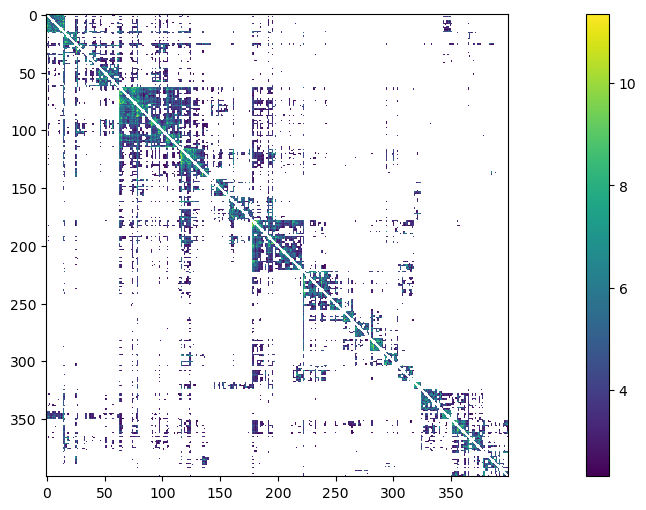

In [11]:
n_ij = (
    jnp.array(
        pd.read_csv("../../../data/processed/incommuters.csv").iloc[:, -1].to_numpy()
    )
    .reshape((400, 400))
    .T
)

plt.imshow(jnp.log(n_ij))
plt.colorbar()
plt.show()

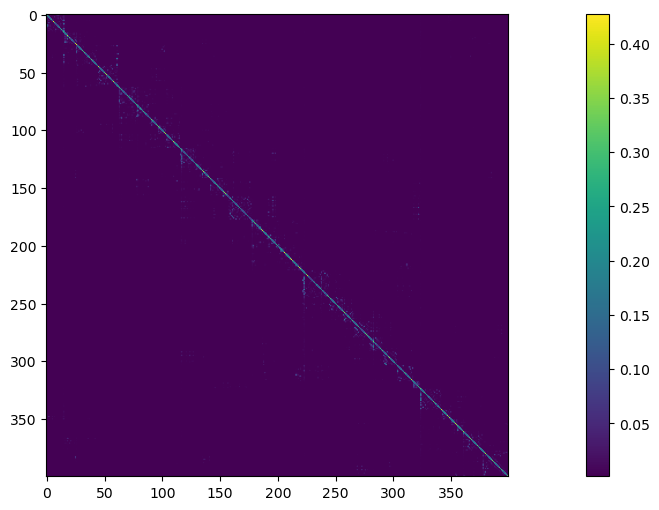

In [12]:
P = _P(1.0, 0.5, n_ij, n_tot)
plt.imshow(P)
plt.colorbar()
plt.show()

In [13]:
df_weekly_cases = (
    pd.read_csv("../../../data/processed/RKI_county_weekly.csv")
    .pivot(index="date", columns="ags", values="cases")
    .iloc[20:]
)


cases_full = df_weekly_cases.to_numpy()
dates_full = df_weekly_cases.index.to_numpy()

In [14]:
# | export
import jax.scipy as jsp

# obs, n_ij, n_tot = aux


def par_to_theta(params):
    alpha, s2_r, s2_spat, q, C, r = params
    return jnp.array(
        [
            jsp.special.logit(alpha),
            jnp.log(s2_r),
            jnp.log(s2_spat),
            jsp.special.logit(q),
            jnp.log(C - 1),
            jnp.log(r),
        ]
    )


def theta_to_par(theta):
    alpha, s2_r, s2_spat, q, Cm1, r = theta
    return jnp.array(
        [
            jsp.special.expit(alpha),
            jnp.exp(s2_r),
            jnp.exp(s2_spat),
            jsp.special.expit(q),
            jnp.exp(Cm1) + 1,
            jnp.exp(r),
        ]
    )


par_manual = jnp.array([0.5, 0.01**2, 0.01**2, 0.5, 2, 100.0])
theta_manual = par_to_theta(par_manual)
np1 = 10
aux = (cases_full[: np1 + 1], n_ij, n_tot)
y = cases_full[1 : np1 + 1]

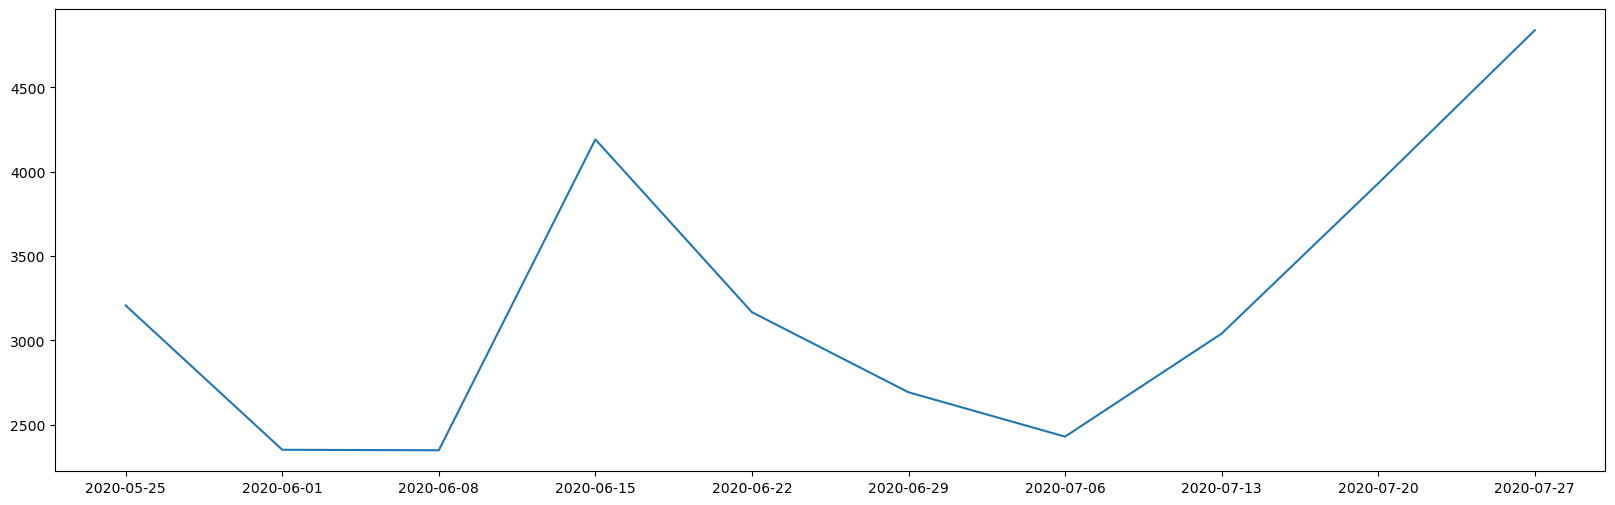

In [15]:
plt.plot(dates_full[1 : np1 + 1], y.sum(axis=-1))
plt.show()

In [16]:
from isssm.estimation import initial_theta

model = growth_factor_model(theta_manual, aux)
theta_manual = jnp.array([
    5.950e+00, -2.063e+00, -5.355e+00, -4.511e-01, -5.711e-01, 7.932e-01
])
theta0_result = initial_theta(y, growth_factor_model, theta_manual, aux, n_iterations)
theta0 = theta0_result.x
theta0_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.483059850892207
        x: [ 5.950e+00 -2.063e+00 -5.355e+00 -4.511e-01 -5.711e-01
             7.932e-01]
      nit: 67
      jac: [-4.044e-06  2.684e-08 -5.043e-06  9.332e-06 -1.170e-06
            -3.219e-06]
 hess_inv: [[ 3.078e+02  2.594e+02 ... -5.167e+02  1.065e+02]
            [ 2.594e+02  1.017e+03 ... -2.559e+02  4.723e+01]
            ...
            [-5.167e+02 -2.559e+02 ...  1.120e+03 -1.870e+02]
            [ 1.065e+02  4.723e+01 ... -1.870e+02  4.998e+01]]
     nfev: 1092
     njev: 84

In [18]:
theta_to_par(theta0)

Array([0.9973998 , 0.12709054, 0.0047229 , 0.38910341, 1.56491673,
       2.21048141], dtype=float64)

In [19]:
fitted_model = growth_factor_model(theta0, aux)

In [20]:
from isssm.laplace_approximation import laplace_approximation as LA

proposal_la, info_la = LA(y, fitted_model, n_iterations)
info_la

ConvergenceInformation(converged=Array(False, dtype=bool), n_iter=Array(20, dtype=int64, weak_type=True), delta=Array(1.90070182e-13, dtype=float64))

In [17]:
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, n_iterations, N_meis, subkey
)
info_meis

ConvergenceInformation(converged=Array(False, dtype=bool), n_iter=Array(20, dtype=int64, weak_type=True), delta=Array(0.00021477, dtype=float64))

In [21]:
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct, log_weights_t

key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y,
    fitted_model,
    proposal_la.z,
    proposal_la.Omega,
    N_mle,
    subkey,
)

ess_pct(lw)

Array(1.00684167, dtype=float64)

In [44]:
from isssm.importance_sampling import mc_integration, prediction


preds = prediction(
    lambda x, s, y: jnp.exp(x[:, :1]),
    y,
    proposal_la,
    model,
    100,
    subkey,
    percentiles_of_interest,
)

In [50]:
preds[2].shape

(23, 10, 1)

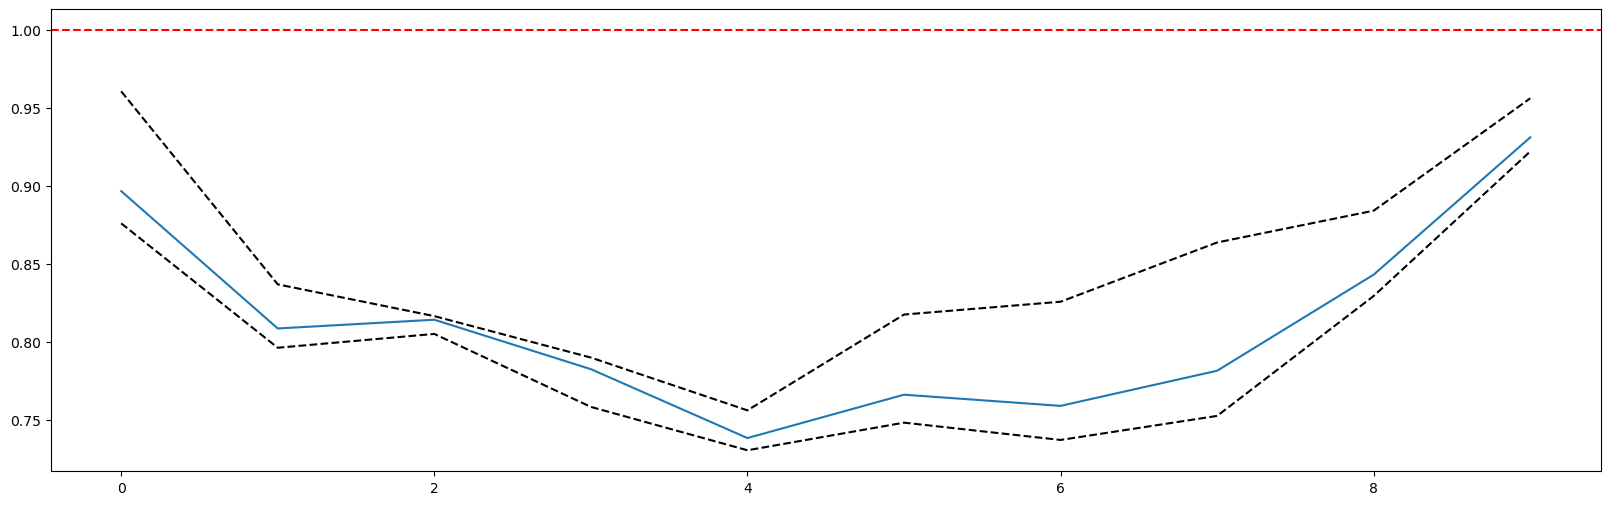

In [55]:
plt.plot(preds[0])
plt.plot(preds[2][1], linestyle="--", color="black")
plt.plot(preds[2][-2], linestyle="--", color="black")
plt.axhline(1, color="red", linestyle="--")
plt.show()

In [18]:
from nbdev import export

export.nb_export("10_model.ipynb", "src")